## Conjunto de dados Banksim

Detecta as transações fraudulentas do conjunto de dados do Banksim. Este conjunto de dados gerado sinteticamente consiste em pagamentos de vários clientes feitos em diferentes períodos de tempo e com diferentes valores. 

Para obter mais informações sobre o conjunto de dados estes experimentos, você pode verificar a página do Kaggle para este conjunto de dados:
https://www.kaggle.com/code/turkayavci/fraud-detection-on-bank-payments/notebook

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [42]:
dados = pd.read_csv('bs140513_032310.csv')

### Verificar as informações do dataset

In [43]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


Os dados de fraude serão desequilibrados como você vê no gráfico abaixo e na contagem de instâncias. 
Para equilibrar o conjunto de dados, pode-se executar técnicas de sobreamostragem ou subamostragem. 

* A sobreamostragem (oversampling) é aumentar o número da classe minoritária gerando instâncias da classe minoritária. 
* A subamostragem é a redução do número de instâncias na classe majoritária, selecionando pontos aleatórios dela para onde é igual à classe minoritária. 

Ambas as operações têm alguns riscos: 
* Oversample criará cópias ou pontos de dados semelhantes que às vezes não seriam úteis para o caso de detecção de fraude porque as transações fraudulentas podem variar. 
* A subamostragem significa que perdemos pontos de dados, portanto, informações. 

Vamos realizar uma técnica de oversampled chamada SMOTE (Synthetic Minority Over-sampling Technique). O SMOTE criará novos pontos de dados da classe minoritária usando as instâncias vizinhas, portanto, as amostras geradas não são cópias exatas, mas são semelhantes às instâncias que temos.

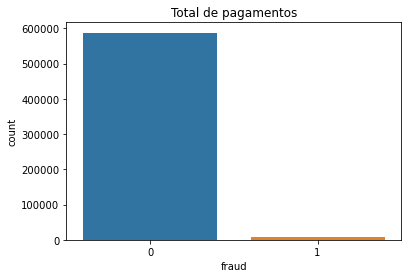

Número de exemplos normais:  step           587443
customer       587443
age            587443
gender         587443
zipcodeOri     587443
merchant       587443
zipMerchant    587443
category       587443
amount         587443
fraud          587443
dtype: int64
Número de exemplos fraudulentos:  step           7200
customer       7200
age            7200
gender         7200
zipcodeOri     7200
merchant       7200
zipMerchant    7200
category       7200
amount         7200
fraud          7200
dtype: int64


In [44]:
dados_fraude = dados.loc[dados.fraud == 1] 
dados_nao_fraude = dados.loc[dados.fraud == 0]

sns.countplot(x="fraud",data=dados)
plt.title("Total de pagamentos")
plt.show()
print("Número de exemplos normais: ",dados_nao_fraude.count())
print("Número de exemplos fraudulentos: ",dados_fraude.count())

### Podemos ver o valor médio e o percentual de fraude por categoria. 

Parece que lazer e as viagens são as categorias mais selecionadas pelos fraudadores. 

Os fraudadores escolheram as categorias nas quais as pessoas gastam mais em média. Vamos confirmar essa hipótese verificando o valor fraudulento e não fraudulento transacionado.

In [45]:
print("Valores médios dos atributos por categoria",dados.groupby('category')['amount','fraud'].mean())

Valores médios dos atributos por categoria                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


### Nossa hipótese para os fraudadores que escolhem as categorias nas quais as pessoas gastam mais é apenas parcialmente correta, mas, como podemos ver na tabela abaixo, podemos dizer com segurança que uma transação fraudulenta será muito mais (cerca de quatro vezes ou mais) do que a média para essa categoria .

In [46]:
# Cria dataframe com dados de fraude e não fraude
pd.concat([dados_fraude.groupby('category')['amount'].mean(),dados_nao_fraude.groupby('category')['amount'].mean(),\
           dados.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


### As categorias de valor médio gasto são semelhantes; entre 0-500 descartando os outliers, exceto para a categoria de viagem que vai para muito alto.

No handles with labels found to put in legend.


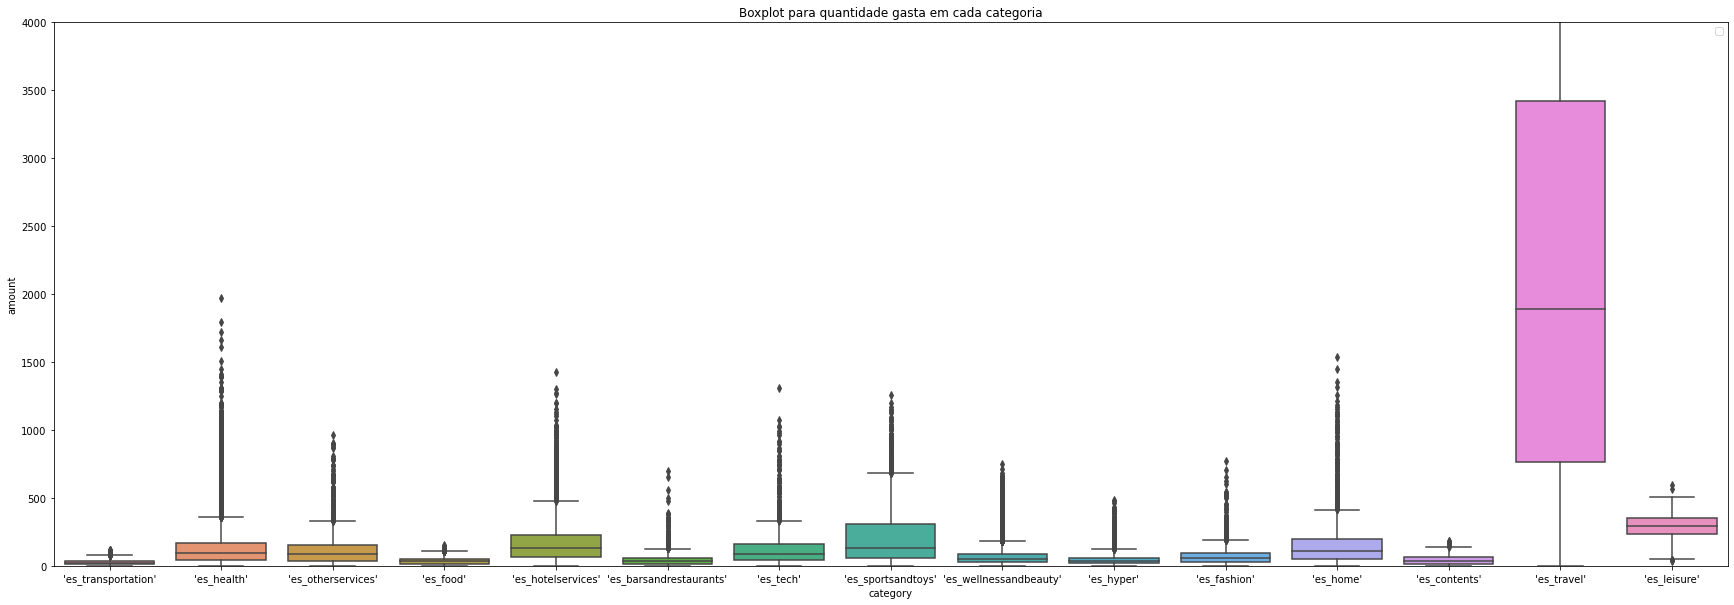

In [47]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=dados.category,y=dados.amount)
plt.title("Boxplot para quantidade gasta em cada categoria")
plt.ylim(0,4000)
plt.legend()
plt.show()

### Mais uma vez, podemos ver no histograma abaixo que as transações fraudulentas são menos contadas, mas mais em quantidade.

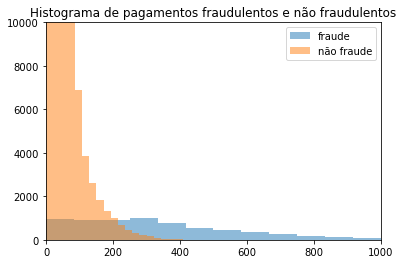

In [48]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(dados_fraude.amount, alpha=0.5, label='fraude',bins=100)
plt.hist(dados_nao_fraude.amount, alpha=0.5, label='não fraude',bins=100)
plt.title("Histograma de pagamentos fraudulentos e não fraudulentos")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

### Parece que a fraude ocorre mais em idades iguais e abaixo de 18 anos. Pode ser porque os fraudadores acham que haveria menos consequências se eles mostrassem sua idade mais jovem, ou talvez eles realmente sejam jovens.

In [49]:
print((dados.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Idade','fraud' : '% de Fraude'}).sort_values(by='% de Fraude'))

  Idade  % de Fraude
7   'U'     0.594228
6   '6'     0.974826
5   '5'     1.095112
1   '1'     1.185254
3   '3'     1.192815
2   '2'     1.251401
4   '4'     1.293281
0   '0'     1.957586


## Pré processamento de dados

Nesta parte iremos pré-processar os dados e nos preparar para o treinamento.

Há apenas um valor único de zipCode, então vamos eliminá-los.

In [50]:
print("Unique zipCodeOri values: ",dados.zipcodeOri.nunique())
print("Unique zipMerchant values: ",dados.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = dados.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


Verificando as colunas depois da exclusão

In [51]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

### Agora vamos transformar atributos categóricos em valores numéricos. 

Geralmente é melhor transformar esses tipos de valores categóricos em fictícios porque eles não têm relação de tamanho (ou seja, cliente1 não é maior que cliente2), mas como são muitos (mais de 500 mil clientes e comerciantes), os recursos crescerão 10 ^ 5 em tamanho e vai demorar uma eternidade para treinar. 


In [52]:
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


### Iniciando a formação os dados para treinamento

Vamos criar as variáveis dependente (classe y) e as independentes X

In [53]:
X = data_reduced.drop(['fraud'],axis=1)
y = dados['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [54]:
y[y==1].count()

7200

### Oversampling com SMOTE
Usando SMOTE (Synthetic Minority Oversampling Technique) para balancear o conjunto de dados. As contagens resultantes mostram que agora temos o número exato de instâncias de classe (1 e 0).

In [32]:
conda install -c conda-forge imbalanced-learn

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\kelly\anaconda3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.14.0               |   py38haa244fe_0         1.0 MB  conda-forge
    imbalanced-learn-0.7.0     |             py_1          97 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

  imbalanced-learn   conda-forge/noarch::imbalanced-learn-0.7.0-py_1
  python_abi         conda-forge/win-64::python_abi-3.8-2_cp38

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.10.1-py38haa95532_1 --> conda-forge::conda-4.14.0-py38haa244fe_0








==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [56]:
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)


In [57]:
y

0         0
1         0
2         0
3         0
4         0
         ..
594638    0
594639    0
594640    0
594641    0
594642    0
Name: fraud, Length: 594643, dtype: int64

In [58]:
y_res

,fraud
0,0
1,0
2,0
3,0
4,0
...,...
1174881,1
1174882,1
1174883,1
1174884,1


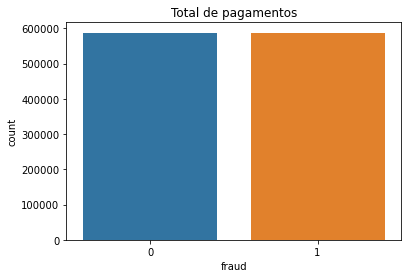

Número de exemplos normais:  fraud    587443
dtype: int64
Número de exemplos fraudulentos:  fraud    587443
dtype: int64


In [71]:
df_fraude = y_res.loc[y_res.fraud == 1] 
df_n_fraude = y_res.loc[y_res.fraud == 0]

sns.countplot(x="fraud",data=y_res)
plt.title("Total de pagamentos")
plt.show()
print("Número de exemplos normais: ",df_fraude.count())
print("Número de exemplos fraudulentos: ",df_n_fraude.count())

### Faremos uma divisão de teste de treino para medir o desempenho. 

Não vamos usar validação cruzada, pois temos muitas instâncias e pode demorar muito o treinamento, mas deve ser melhor validar cruzada na maioria das vezes.

In [61]:
## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

### Vamos uma função para traçar a curva ROC_AUC. É uma boa maneira visual de ver o desempenho da classificação.

In [63]:
# %% Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('AUC do treinamento')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Verdadeiros positivos')
    plt.xlabel('Falsos positivos')
    plt.show()

Como falei sobre isso antes, os conjuntos de dados de fraude serão desequilibrados e a maioria das instâncias não será fraudulenta. 

Imagine que temos o conjunto de dados aqui e estamos sempre prevendo não fraudulentos. Nossa precisão seria de quase 99% para este conjunto de dados e principalmente para outros, pois a porcentagem de fraude é muito baixa. Nossa precisão é muito alta, mas não detectamos nenhuma fraude, portanto, é um classificador inútil. 

Portanto, a pontuação de precisão básica deve ser melhor, pelo menos, do que prever sempre não fraudulento para realizar uma detecção.

In [65]:
print("A pontuação de precisão básica que devemos vencer é: ", 
      dados_nao_fraude.fraud.count()/ np.add(dados_nao_fraude.fraud.count(),dados_fraude.fraud.count()) * 100)

A pontuação de precisão básica que devemos vencer é:  98.7891894800746


### K vizinhos mais próximos

Resultado de classificação usando KNN: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Matriz de confusão: 
 [[171999   4234]
 [   362 175871]]


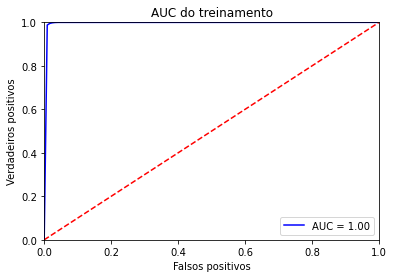

In [66]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Resultado de classificação usando KNN: \n", classification_report(y_test, y_pred))
print("Matriz de confusão: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

### Random Forest

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


Resultado de classificação usando Random Forest: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Matriz de confusão: 
 [[170106   6127]
 [  1079 175154]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


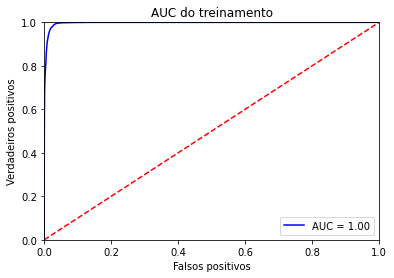

In [68]:
# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Resultado de classificação usando Random Forest: \n", classification_report(y_test, y_pred))
print("Matriz de confusão: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

### Referências

[1]. Lavion, Didier; et al. "PwC's Global Economic Crime and Fraud Survey 2018" (PDF). PwC.com. Retrieved 28 August 2018.

[2]. SMOTE: Synthetic Minority Over-sampling Technique